In [1]:
import pyOSC3
import time
import random
import copy
from collections import namedtuple, defaultdict
from subprocess import Popen
import numpy as np
import math
import json
np.set_printoptions(precision=3)

from chord_utils import *
from elia_lrde_chords import *

In [2]:
client = pyOSC3.OSCClient()
client.connect(('127.0.0.1', 57120))

In [3]:
chords = get_chords()

redux_cents = \
    [1507, 1679, 1781, 1851, 1902, 2004,
     2055, 2106, 2208, 2227, 2259, 2329, 2380, 2399,
     2431, 2482, 2501, 2552, 2584, 2603, 2622, 2654, 2673,
     2724, 2756, 2775, 2877]
# description of redux system (which is bad, actually):
# basic intervals: 102, 153, 172
# we also use equality: 102*3 = 153*2
# 1507 = 2055 - 102*2       - 172*2
# 1679 = 2055 - 102*2       - 172
# 1781 = 2055 - 102         - 172
# 1851 = 2055 - 102*2
# 2004 = 2055 + 102   - 153
# 2055
# 2106 = 2055 - 102   + 153
# 2208 = 2055         + 153
# 2227 = 2055               + 172
# 2259 = 2055 + 102*2
# 2329 = 2055 + 102         + 172
# 2380 = 2055         + 153 + 172
# 2399 = 2055               + 172*2
# 2431 = 2055 + 102*2       + 172
# 2482 = 2055 + 102   + 153 + 172
# 2501 = 2055 + 102         + 172*2
# 2552 = 2055         + 153 + 172*2
# 2584 = 2055 + 102*2 + 153 + 172
# 2603 = 2055 + 102*2       + 172*2
# 2622 = 2055 - 102   + 153 + 172*3
# 2654 = 2055 + 102   + 153 + 172*2
# 2724 = 2055         + 153 + 172*3
# 2756 = 2055 + 102*2 + 153 + 172*2
# 2775 = 2055 + 102*2       + 172*3
# 2877 = 2055 + 102*3       + 172*3

check_chords(chords, redux_cents)
for c in chords:
    print(c.tony)

[None, 2728, None]
[None, 2545, None]
[None, 2409, None]
[None, 2226, None]
[None, 2564, None]
[None, 2538, None]
[2025, 2397, 2727]
[2048, 2507, 2727]
[2031, 2482, 2727]
[2084, 2507, 2756]
[2037, 2476, 2728]
[1786, 2333, 2620]
[1508, 2423, None]
[1653, 2070, 2410]
[1862, 2417, 2547]
[1862, 2269, 2597]
[2056, 2083, 2089]
[2059, 2541, 2759]
[2059, 2564, 2767]
[2059, None, 2794]
[2011, 2535, 2794]
[2053, 2401, 2794]
[1819, 2238, 2695]
[1713, 2554, 2884]
[1701, 2558, 2884]
[1653, 2368, 2769]
[1604, 2199, 2649]
[None, 2327, 2218]
[1655, 2065, 2375]
[1850, 2371, 2716]
[1850, 2225, 2548]
[2068, 2068, 2066]
[2032, 2522, 2764]
[2038, 2568, 2793]
[1677, 2364, 2758]
[1677, 2364, 2358]
[1827, 2190, 2546]
[2022, 2533, 2751]
[2005, 2575, 2738]
[1685, 2388, 2394]
[1781, 2226, 2545]
[2021, 2513, 2745]
[2021, 2569, 2745]
[2021, 2383, 2745]
[2021, 2570, 2745]
[2021, 2546, 2745]
[2073, 2583, 2756]
[2071, 2391, 2716]
[1775, 2248, 2559]
[1508, 2248, 2559]
[1672, 2082, 2394]
[1874, 2399, 2551]
[1874, 2265,

In [4]:
# proc = Popen(['afplay', '/Users/a1111/Downloads/GVM097_KristeAghsdga_MVCM.mp3'])


def send_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")

        msg.append([note, cur_timbre, out_bus_idx])
        # print('sent', note,'to', out_bus_idx)
        client.send(msg)
#         time.sleep(0.001)
    except Exception as e:
        pass

ref_hz = 110

prev_time = 0
sleep_time = chords[0].timestamp
# time.sleep(sleep_time)

for idx, chord in enumerate(chords):
    if idx + 1 < len(chords):
        sleep_time = chords[idx + 1].timestamp - chords[idx].timestamp
    else:
        sleep_time = 2
    tony_no_nan = []
    redux_no_nan = []
    gvm_no_nan = []
    for j, p in enumerate(chord.tony):
        if p is not None:
            tony_no_nan.append(p)
            redux_no_nan.append(chord.redux[j])
            gvm_no_nan.append(chord.gvm[j])

    warning = ''
    diff = np.max(np.abs(np.array(tony_no_nan) - redux_no_nan))
    diff = np.max(np.abs(np.array(tony_no_nan) - gvm_no_nan))
    if diff > 25:
        warning = '!!!'
    print(idx, chord.syllable, chord.gvm, chord.tony, chord.redux, warning)
#     continue
    gvm_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.gvm]
    tony_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.tony]
    redux_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.redux]
#     for hz in gvm_hzs:
    for hz in tony_hzs:
        send_msg(hz, 0, 0)
    time.sleep(sleep_time)
# proc.terminate()


0 e [None, 2727, None] [None, 2728, None] [None, 2756, None] 
1 lya [None, 2545, None] [None, 2545, None] [None, 2584, None] 
2 lar [None, 2409, None] [None, 2409, None] [None, 2431, None] 
3 de [None, 2225, None] [None, 2226, None] [None, 2259, None] 
4 i [None, 2565, None] [None, 2564, None] [None, 2584, None] 
5

KeyboardInterrupt: 

In [4]:
def normalize(r):
    n = [r[0], r[1]]
    while 2 <= n[0] / n[1]:
        n[1] *= 2
    while n[0] / n[1] <= 1:
        n[0] *= 2
    return tuple(n)

# wilson41
# crystal growth algorithm
primes = [3, 5, 7, 11, 13]
ratios = [(1, 1), (2, 1)]
for i, p in enumerate(primes):
    if p == 13:
        break
    r1 = [p, 1]
    max_deg = len(primes) - i
    if p == 3:
        max_deg -= 1
    for j in range(max_deg):
        ratios.append(normalize(tuple(r1)))
        r1i = [r1[1], r1[0]]
        ratios.append(normalize(tuple(r1i)))
        r1[0] *= 3
    if p == 3:
        continue
    r1 = [p, 3]
    for j in range(1, max_deg):
        ratios.append(normalize(tuple(r1)))
        r1i = [r1[1], r1[0]]
        ratios.append(normalize(tuple(r1i)))
        r1[1] *= 3

odds = [1, 3, 5, 7, 9, 11]
for p1 in odds:
    for p2 in odds:
        if p1 == p2:
            continue
        if min(p1, p2) != 1 and (max(p1, p2) % min(p1, p2) == 0):
            continue
        # wilson example
        # if (p1, p2) in [(11, 5), (5, 11)]:
            # continue
        r = (p1, p2)
        r = normalize(r)
        if r not in ratios:
            ratios.append(r)

# ratios.sort(key=lambda r: util.ratio_to_cents(r[0], r[1]))
print('ratios count', len(ratios))


ratios count 48


In [65]:
cents_tolerance = 5 # 100 / 8

ref_hz = 55

main_pitch_in_cents = 2070
main_pitch_in_hz = calc_hz(main_pitch_in_cents, ref_hz)

ret_sort = sorted(redux_cents)
ret_sort = np.array(ret_sort) - main_pitch_in_cents
print(ret_sort)

intervals = [defaultdict(int), defaultdict(int), defaultdict(int)]
intervals_as_pairs = [dict(), dict(), dict()]
intervals_as_ji = dict()

all_intervals = defaultdict(int)
all_intervals_as_pairs = dict()

cents_count = [defaultdict(int), defaultdict(int), defaultdict(int)]
all_cents_count = defaultdict(int)

all_chords = defaultdict(int)
for chord in chords:
    pitches = chord.tony#redux
    pitches_for_diff = []
    pitches_in_hz = []
    pitches_in_cents = []
    pitches_in_cents_with_none = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            pitches_in_cents_with_none.append(None)
            continue
        cents_count[p_idx][pitch] += 1
        all_cents_count[pitch] += 1
        pitches_for_diff.append(pitch)
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz / main_pitch_in_hz)
        pitch_in_cents = int(ratio_to_cents(pitch_in_hz, main_pitch_in_hz))
        pitches_in_cents.append(pitch_in_cents)
        pitches_in_cents_with_none.append(pitch_in_cents)

    # chord intervals
    if len(pitches_for_diff) <= 1:
        diffs = []
    elif len(pitches_for_diff) == 2:
        diffs = [pitches_for_diff[1] - pitches_for_diff[0]]
    else:
        diffs = [pitches_for_diff[2] - pitches_for_diff[0],
                 pitches_for_diff[2] - pitches_for_diff[1],
                 pitches_for_diff[1] - pitches_for_diff[0]]
        pairs = [(pitches_for_diff[0], pitches_for_diff[2]),
                 (pitches_for_diff[1], pitches_for_diff[2]),
                 (pitches_for_diff[0], pitches_for_diff[1])]

        for k in range(3):
            intervals[k][diffs[k]] += 1
            all_intervals[diffs[k]] += 1
            if diffs[k] not in intervals_as_pairs[k]:
                intervals_as_pairs[k][diffs[k]] = set()
            if diffs[k] not in all_intervals_as_pairs:
                all_intervals_as_pairs[diffs[k]] = set()
            intervals_as_pairs[k][diffs[k]].add(pairs[k])
            all_intervals_as_pairs[diffs[k]].add(pairs[k])
        ch = tuple(diffs)
        all_chords[ch] += 1

    diffs = [abs(c) for c in diffs]

    notes = []
    for i, p in enumerate(diffs):
        n = str(diffs[i]) + 'c'
        state = ''
        for r in ratios:
            c1 = diffs[i]
            c2 = ratio_to_cents(r[0], r[1])
            check1 = abs(c1 - c2) < cents_tolerance
            check2 = abs(c1 - c2) < cents_tolerance * 1.5
            add = ''
            if check2 and not check1:
                add = '?'
            if check2:
                if r == (1, 1):
                    state = '.' + add
                else:
                    state = 'ji'
                    n += ' ' + add + str(r[0]) + '/' + str(r[1])
        notes.append((n, state))
    print(chord.syllable, pitches, notes)

    if len(diffs) == 3:
        for k in range(3):
            pretty = ' '.join(notes[k][0].split(' ')[1:])
            intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]

for i in range(3):
    print(i)
    for k in sorted(intervals[i].keys()):
        print(k, intervals[i][k], intervals_as_pairs[i][k], intervals_as_ji[abs(k)])
    print()

print('all intervals')
for k in sorted(all_intervals.keys()):
    print(k, all_intervals[k], all_intervals_as_pairs[k], intervals_as_ji[abs(k)])
print()

    
print('cents counts')
for i in range(3):
    print(i)
    for k in sorted(cents_count[i].keys()):
        print(k, cents_count[i][k])
    print()

print('all cents')
for k in sorted(all_cents_count.keys()):
    print(k, all_cents_count[k])
print()

print('all chords')
for ch in sorted(all_chords.keys()):
    print(all_chords[ch], ch)

[-563 -391 -289 -219 -168  -66  -15   36  138  157  189  259  310  329
  361  412  431  482  514  533  552  584  603  654  686  705  807]
e [None, 2728, None] []
lya [None, 2545, None] []
lar [None, 2409, None] []
de [None, 2226, None] []
i [None, 2564, None] []
i [None, 2538, None] []
la [2025, 2397, 2727] [('702c 3/2', 'ji'), ('330c', ''), ('372c', '')]
i/qi [2048, 2507, 2727] [('679c 40/27', 'ji'), ('220c', ''), ('459c', '')]
le/me [2031, 2482, 2727] [('696c ?3/2', 'ji'), ('245c', ''), ('451c', '')]
i [2084, 2507, 2756] [('672c', ''), ('249c', ''), ('423c ?14/11', 'ji')]
a [2037, 2476, 2728] [('691c', ''), ('252c', ''), ('439c 9/7', 'ji')]
uo [1786, 2333, 2620] [('834c', ''), ('287c ?32/27', 'ji'), ('547c 11/8', 'ji')]
o [1508, 2423, None] [('915c', '')]
o/le [1653, 2070, 2410] [('757c', ''), ('340c ?11/9', 'ji'), ('417c 14/11', 'ji')]
si [1862, 2417, 2547] [('685c 40/27', 'ji'), ('130c', ''), ('555c 11/8', 'ji')]
a [1862, 2269, 2597] [('735c ?32/21', 'ji'), ('328c', ''), ('407c 81/

708 1 {(2059, 2767)} ?3/2 ji
709 1 {(1685, 2394)} ?3/2 ji
715 1 {(1653, 2368)}  
719 1 {(1827, 2546)}  
720 1 {(1655, 2375)}  
722 1 {(1672, 2394)} ?32/21 ji
724 5 {(2021, 2745)} ?32/21 ji
727 1 {(2051, 2778)} 32/21 ji
729 1 {(2022, 2751)} 32/21 ji
731 1 {(1847, 2578)} 32/21 ji
732 1 {(2032, 2764)} 32/21 ji
733 1 {(2005, 2738)} 32/21 ji
735 1 {(1862, 2597)} ?32/21 ji
740 1 {(1508, 2248)}  
741 1 {(2053, 2794)}  
755 1 {(2038, 2793)}  
757 1 {(1653, 2410)}  
764 1 {(1781, 2545)} 14/9 ji
783 1 {(2011, 2794)} 11/7 ji
784 1 {(1775, 2559)} 11/7 ji
788 1 {(1887, 2675)} 128/81 ?11/7 ji
834 1 {(1786, 2620)}  
840 1 {(1731, 2571)}  
841 1 {(1713, 2554)}  
857 1 {(1701, 2558)} 18/11 ji
865 1 {(1691, 2556)}  
866 2 {(1850, 2716), (1882, 2748)}  
876 1 {(1819, 2695)}  
988 1 {(1637, 2625)}  
1045 1 {(1604, 2649)} 11/6 ji
1051 1 {(1508, 2559)} 11/6 ji
1078 1 {(1673, 2751)}  
1081 1 {(1677, 2758)} ?15/8 ji
1116 1 {(1653, 2769)}  
1150 1 {(1731, 2881)} 64/33 ji
1171 1 {(1713, 2884)} 63/32 ji
1183 1 {

In [282]:
print(len(redux_cents))
print(sorted(redux_cents))

28
[1507, 1679, 1781, 1851, 1902, 2004, 2055, 2106, 2208, 2227, 2259, 2329, 2380, 2399, 2431, 2482, 2501, 2552, 2584, 2584, 2603, 2622, 2654, 2673, 2724, 2756, 2775, 2877]


In [318]:
cents_tolerance = 100 / 8

ref_hz = 55

main_pitch_in_cents = 2055
main_pitch_in_hz = calc_hz(main_pitch_in_cents, ref_hz)

ret_sort = sorted(redux_cents)
ret_sort = np.array(ret_sort) - main_pitch_in_cents
print(ret_sort)

intervals = [defaultdict(int), defaultdict(int), defaultdict(int)]
intervals_as_pairs = [dict(), dict(), dict()]
intervals_as_ji = dict()

all_intervals = defaultdict(int)
all_intervals_as_pairs = dict()

cents_count = [defaultdict(int), defaultdict(int), defaultdict(int)]
all_cents_count = defaultdict(int)

all_steps = defaultdict(int)
for voice in [1]:
    print()
    print('voice', voice)
    steps = defaultdict(int)
    prev_pitch = None
    for chord in chords:
        cur_pitch = chord.redux[voice]
        if prev_pitch is not None and cur_pitch is not None:
            step = cur_pitch - prev_pitch
            steps[abs(step)] += 1
            all_steps[abs(step)] += 1
            print('step', step, prev_pitch, cur_pitch)
        print(cur_pitch, chord.syllable)
        prev_pitch = cur_pitch
    print('steps')
    for s in steps:
        print(s, steps[s])

print()
print('all steps')
for s in all_steps:
    print(s, all_steps[s])


#         pitches_for_diff = []
#         pitches_in_hz = []
#         pitches_in_cents = []
#         pitches_in_cents_with_none = []
#         for p_idx, pitch in enumerate(pitches):
#             if pitch is None:
#                 pitches_in_cents_with_none.append(None)
#                 continue
#             cents_count[p_idx][pitch] += 1
#             all_cents_count[pitch] += 1
#             pitches_for_diff.append(pitch)
#             pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
#             pitches_in_hz.append(pitch_in_hz / main_pitch_in_hz)
#             pitch_in_cents = int(ratio_to_cents(pitch_in_hz, main_pitch_in_hz))
#             pitches_in_cents.append(pitch_in_cents)
#             pitches_in_cents_with_none.append(pitch_in_cents)

#         notes = []
#         for i, p in enumerate(diffs):
#             n = str(diffs[i]) + 'c'
#             state = ''
#             for r in ratios:
#                 c1 = diffs[i]
#                 c2 = ratio_to_cents(r[0], r[1])
#                 check1 = abs(c1 - c2) < cents_tolerance
#                 check2 = abs(c1 - c2) < cents_tolerance * 1.5
#                 add = ''
#                 if check2 and not check1:
#                     add = '?'
#                 if check2:
#                     if r == (1, 1):
#                         state = '.' + add
#                     else:
#                         state = 'ji'
#                         n += ' ' + add + str(r[0]) + '/' + str(r[1])
#             notes.append((n, state))
#     #     print(chord.syllable, pitches, notes)

#         if len(diffs) == 3:
#             for k in range(3):
#                 pretty = ' '.join(notes[k][0].split(' ')[1:])
#                 intervals_as_ji[diffs[k]] = pretty + ' ' + notes[k][1]


[-548 -376 -274 -204 -153  -51    0   51  153  172  204  274  325  344
  376  427  446  497  529  548  567  599  618  669  701  720  822]

voice 1
2756 e
step -172 2756 2584
2584 lya
step -153 2584 2431
2431 lar
step -172 2431 2259
2259 de
step 325 2259 2584
2584 i
step -32 2584 2552
2552 i
step -121 2552 2431
2431 la
step 70 2431 2501
2501 i/qi
step -19 2501 2482
2482 le/me
step 19 2482 2501
2501 i
step -19 2501 2482
2482 a
step -153 2482 2329
2329 uo
step 70 2329 2399
2399 o
step -344 2399 2055
2055 o/le
step 376 2055 2431
2431 si
step -172 2431 2259
2259 a
step -204 2259 2055
2055 uo
step 497 2055 2552
2552 a/sa
step 0 2552 2552
2552 i
None i/a
2552 a/da
step -153 2552 2399
2399 a/ma/ua
step -172 2399 2227
2227 a
step 325 2227 2552
2552 ki
step 0 2552 2552
2552 ri
step -172 2552 2380
2380 o/a
step -153 2380 2227
2227 uo/ra/a
step 102 2227 2329
2329 o/a
step -274 2329 2055
2055 le
step 325 2055 2380
2380 si/ri
step -153 2380 2227
2227 a
step -172 2227 2055
2055 uo
step 497 2055 2552


In [14]:
def max_prime_factor(n):
    max_prime = 1
    while n % 2 == 0:
        max_prime = 2
        n //= 2
    for i in range(3, int(n ** 0.5) + 1, 2):
        while n % i == 0:
            max_prime = i
            n = n // i
    if n > 2:
        max_prime = n
    return max_prime


cents_tolerance = 5

main_pitch_in_hz = 55

all_best_round_scaled = defaultdict(int)
all_intervals = defaultdict(int)
# todo: add max prime to use

max_prime = 17
for chord in chords:
    pitches = chord.tony
    pitches_in_hz = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz)

    if len(pitches_in_hz) < 3:
        continue

    best_cents_round = None
    best_round_scaled = None
    best_cents_diff = None
    warning = '!!!'
    for b in range(1, 100):
        for shift in range(0, cents_tolerance + 1):
            for sign in [1, -1]:
                if shift == 0 and sign == -1:
                    break
                base_in_cents = chord.tony[0] + shift * sign
                base_in_hz = calc_hz(base_in_cents, main_pitch_in_hz)
                normed = []
                for p in pitches_in_hz:
                    normed.append(p / base_in_hz)
                scaled = [b, min(normed[1:]) * b, max(normed[1:]) * b]
                round_scaled = [round(x) for x in scaled]
                all_good = True
                for v in round_scaled:
                    p = max_prime_factor(v)
                    if p > max_prime:
                        all_good = False
                        break
                if not all_good:
                    continue
                hz_round = [x / b * base_in_hz for x in round_scaled]
                cents_round = [round(cents_from_hz(hz, main_pitch_in_hz)) for hz in hz_round]
                cents_diff = np.max(np.abs(np.array(chord.tony) - cents_round))
                if best_cents_diff is None or cents_diff < best_cents_diff:
                    best_cents_diff = cents_diff
                    best_round_scaled = round_scaled
                    best_cents_round = cents_round
                    if best_cents_diff > cents_tolerance:
                        warning = '!!!'
                    else:
                        warning = ''
                        break
            if not warning:
                break
        if not warning:
            break
    
    if not warning:
        all_best_round_scaled[tuple(best_round_scaled)] += 1
        for p in [(0, 1), (0, 2), (1, 2)]:
            a = best_round_scaled[p[0]]
            b = best_round_scaled[p[1]]
            all_intervals[(b // math.gcd(a, b), a // math.gcd(a, b))] += 1

    print(chord.tony, best_cents_diff,
          best_round_scaled,# np.array([x / best_round_scaled[0] for x in best_round_scaled]),
          best_cents_round, chord.syllable, warning)

# print()
# print('chords')
# for k in all_best_round_scaled:
#     print(k, all_best_round_scaled[k])

# print()
# print('intervals')
# for k in all_intervals:
#     print(k, all_intervals[k])

[2025, 2397, 2727] 5 [34, 42, 51] [2026, 2392, 2728] la 
[2048, 2507, 2727] 5 [52, 68, 77] [2048, 2512, 2728] i/qi 
[2031, 2482, 2727] 5 [10, 13, 15] [2030, 2484, 2732] le/me 
[2084, 2507, 2756] 5 [44, 56, 65] [2084, 2502, 2760] i 
[2037, 2476, 2728] 5 [35, 45, 52] [2038, 2473, 2723] a 
[1786, 2333, 2620] 5 [8, 11, 13] [1784, 2335, 2625] uo 
[1653, 2070, 2410] 3 [11, 14, 17] [1653, 2071, 2407] o/le 
[1862, 2417, 2547] 5 [35, 48, 52] [1865, 2412, 2550] si 
[1862, 2269, 2597] 3 [64, 81, 98] [1862, 2270, 2600] a 
[2056, 2083, 2089] 5 [48, 49, 49] [2052, 2088, 2088] uo 
[2059, 2541, 2759] 3 [34, 45, 51] [2059, 2544, 2761] a/sa 
[2059, 2564, 2767] 5 [6, 8, 9] [2061, 2559, 2763] i 
[2011, 2535, 2794] 4 [40, 54, 63] [2011, 2531, 2797] a/da 
[2053, 2401, 2794] 5 [32, 39, 49] [2054, 2396, 2792] a/ma/ua 
[1819, 2238, 2695] 5 [33, 42, 55] [1816, 2234, 2700] a 
[1713, 2554, 2884] 2 [32, 52, 63] [1713, 2554, 2886] ki 
[1701, 2558, 2884] 5 [33, 54, 65] [1705, 2558, 2879] ri 
[1653, 2368, 2769] 4 [33

In [17]:
cents_tolerance = 5

main_pitch_in_hz = 55

all_best_round_scaled = defaultdict(int)
all_intervals = defaultdict(int)
# todo: add max prime to use

for chord in chords:
    pitches = chord.tony
    pitches_no_none = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitches_no_none.append(pitch)

    if len(pitches_no_none) < 3:
        continue
    diffs = [abs(pitches_no_none[2] - pitches_no_none[0]),
             abs(pitches_no_none[2] - pitches_no_none[1]),
             abs(pitches_no_none[1] - pitches_no_none[0])]

    best_cents_diff = None
    best_diff_steps = None
    best_edo_diffs = None
    best_base = None
    warning = '!!!'
    for b in range(5, 53):
        step = 1200 / b
        for shift in range(0, cents_tolerance + 1):
            cents_diff = []
            diff_steps = []
            edo_diffs = []
            for d in diffs:
                cents_diff.append(abs(d - round(d / step) * step))
                diff_steps.append(round(d / step))
                edo_diffs.append(round(round(d / step) * step))
            if best_cents_diff is None or max(cents_diff) < best_cents_diff:
                best_cents_diff = max(cents_diff)
                best_diff_steps = diff_steps
                best_base = b
                best_edo_diffs = edo_diffs
                if best_cents_diff > cents_tolerance:
                    warning = '!!!'
                else:
                    warning = ''
                    break
        if not warning:
            break

    print(chord.tony, round(best_cents_diff), '; ', best_base, best_diff_steps,
          diffs, best_edo_diffs, chord.syllable, warning)


[2025, 2397, 2727] 1 ;  29 [17, 8, 9] [702, 330, 372] [703, 331, 372] la 
[2048, 2507, 2727] 5 ;  39 [22, 7, 15] [679, 220, 459] [677, 215, 462] i/qi 
[2031, 2482, 2727] 5 ;  24 [14, 5, 9] [696, 245, 451] [700, 250, 450] le/me 
[2084, 2507, 2756] 2 ;  34 [19, 7, 12] [672, 249, 423] [671, 247, 424] i 
[2037, 2476, 2728] 4 ;  19 [11, 4, 7] [691, 252, 439] [695, 253, 442] a 
[1786, 2333, 2620] 4 ;  33 [23, 8, 15] [834, 287, 547] [836, 291, 545] uo 
[1653, 2070, 2410] 1 ;  46 [29, 13, 16] [757, 340, 417] [757, 339, 417] o/le 
[1862, 2417, 2547] 2 ;  28 [16, 3, 13] [685, 130, 555] [686, 129, 557] si 
[1862, 2269, 2597] 2 ;  44 [27, 12, 15] [735, 328, 407] [736, 327, 409] a 
[2056, 2083, 2089] 6 ;  37 [1, 0, 1] [33, 6, 27] [32, 0, 32] uo !!!
[2059, 2541, 2759] 4 ;  50 [29, 9, 20] [700, 218, 482] [696, 216, 480] a/sa 
[2059, 2564, 2767] 7 ;  47 [28, 8, 20] [708, 203, 505] [715, 204, 511] i !!!
[2011, 2535, 2794] 2 ;  23 [15, 5, 10] [783, 259, 524] [783, 261, 522] a/da 
[2053, 2401, 2794] 5 ; 

In [7]:
cents_tolerance = 8

main_pitch_in_hz = 55

relations = []

for chord in chords:
    pitches = chord.tony
    pitches_in_hz = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz)

    if len(pitches_in_hz) < 3:
        continue
    pitches_in_hz.sort()
    relation = [pitches_in_hz[1] / pitches_in_hz[0], pitches_in_hz[2] / pitches_in_hz[0]]
    relations.append((relation, chord.tony, chord.syllable))

# relations.sort()
ref_hz = 110

for r in relations:
    hzs = [calc_hz(pitch, ref_hz) for pitch in r[1]]
    normed_hzs = [h / hzs[0] * 440 for h in hzs]
    for hz in normed_hzs:
        send_msg(hz, 0, 0)
    normed_cents = [p - r[1][0] + 2070 for p in r[1]]
    print(normed_cents, r)
#     time.sleep(1.)


[2070, 2442, 2772] ([1.2397076999389864, 1.5000389892858181], [2025, 2397, 2727], 'la')
[2070, 2529, 2749] ([1.303598864021176, 1.4802422838278095], [2048, 2507, 2727], 'i/qi')
[2070, 2521, 2766] ([1.2975888549373724, 1.4948492486349385], [2031, 2482, 2727], 'le/me')
[2070, 2493, 2742] ([1.2767711873336003, 1.4742692172911016], [2084, 2507, 2756], 'i')
[2070, 2509, 2761] ([1.2886257540010413, 1.490538183129046], [2037, 2476, 2728], 'a')
[2070, 2617, 2904] ([1.3715748289001866, 1.6188844330948169], [1786, 2333, 2620], 'uo')
[2070, 2487, 2827] ([1.2723538945964745, 1.5484591603563702], [1653, 2070, 2410], 'o/le')
[2070, 2625, 2755] ([1.3779275169257046, 1.4853813127703919], [1862, 2417, 2547], 'si')
[2070, 2477, 2805] ([1.2650256754095057, 1.5289063075030107], [1862, 2269, 2597], 'a')
[2070, 2097, 2103] ([1.0157180609309646, 1.0192443785950769], [2056, 2083, 2089], 'uo')
[2070, 2552, 2770] ([1.3210331469276786, 1.4983070768766817], [2059, 2541, 2759], 'a/sa')
[2070, 2575, 2778] ([1.33870

In [403]:
class Cook2009:
    """
    Maximum dissonance normalized to 1.0.
    Fixes compared to the paper:
    - there's one more minus sign when applying beta_1, beta_2
    - logarithm should be of base 2
    - log2(f_2 / f_1) needs to be multiplied by 12 to get the 12-TET semitone
      interval
    It also contains models of tension and modality of a triad.
    """
    beta_1 = -0.8
    beta_2 = -1.6
    beta_3 = 4.0
    alpha = 0.6
    epsilon = 1.558

    def dissonance_pair(self, f_1, f_2, a_1, a_2):
        spl = a_1 * a_2
        # frequency ratio -> 12-TET semitone interval
        x = 12 * np.log2(f_2 / f_1)
        d = np.exp(self.beta_1 * x) - np.exp(self.beta_2 * x)
        return spl * self.beta_3 * d

    def tension_triad(self, f_1, f_2, f_3, a_1, a_2, a_3):
        x = 12 * np.log2(f_2 / f_1)
        y = 12 * np.log2(f_3 / f_2)
        # originally named v (greek nu)
        spl = a_1 * a_2 * a_3
        return spl * np.exp(-((y - x) / self.alpha) ** 2)

    def modality_triad(self, f_1, f_2, f_3, a_1, a_2, a_3):
        x = 12 * np.log2(f_2 / f_1)
        y = 12 * np.log2(f_3 / f_2)
        # originally named v (greek nu)
        spl = a_1 * a_2 * a_3
        return -spl * (2 * (y - x) / self.epsilon) * np.exp(-(y - x) ** 4 / 4)


def assert_nonnegative(values):
    for v in values:
        assert np.all(v >= 0)
    
def dissonance_pair(f_1, f_2, a_1, a_2, model):
    """
    Computes the dissonance metric for a pair(s) of sinusoidal tones with given
    frequency and amplitude using the specified model.
    The parameters can be either a single value or a numpy array. In the latter
    case the computation is vectorized for the whole array.
    Parameters:
    f_1 - lower frequencies
    f_2 - upper frequencies
    a_1 - amplitudes for f_1
    a_2 - amplitudes for f_2
    model - known model name (see list_models())
    Returns:
    dissonance - a single value or array
    """
    assert_nonnegative((f_1, f_2, a_1, a_2))
    if type(model) == str:
        model = Cook2009()
    return model.dissonance_pair(f_1, f_2, a_1, a_2)


def dissonance(freqs, amps, model='cook2009', aggregation=lambda d: d.sum()):
    """
    Computes dissonance score for chord composed of muliple frequences,
    each possible with different amplitudes using a given dissonance model.
    """
    f1s = []
    f2s = []
    a1s = []
    a2s = []
    for i1, f1 in enumerate(freqs[0]):
        for i2, f2 in enumerate(freqs[1]):
            if f1 < f2:
                f1s.append(f1)
                f2s.append(f2)
                a1s.append(amps[0][i1])
                a2s.append(amps[1][i2])
            else:
                f1s.append(f2)
                f2s.append(f1)
                a1s.append(amps[1][i2])
                a2s.append(amps[0][i1])
    f1s = np.array(f1s)
    f2s = np.array(f2s)
    a1s = np.array(a1s)
    a2s = np.array(a2s)
    dissonances = dissonance_pair(f1s, f2s, a1s, a2s, model)
    return aggregation(dissonances)


def modality_triad(f_1, f_2, f_3, a_1, a_2, a_3, model):
    """
    Computes the modality metric for a triple(s) of sinusoidal tones with given
    frequency and amplitude using the specified model.
    The parameters can be either a single value or a numpy array. In the latter
    case the computation is vectorized for the whole array.
    Parameters:
    f_1 - lower frequencies
    f_2 - middle frequencies
    f_3 - upper frequencies
    a_1 - amplitudes for f_1
    a_2 - amplitudes for f_2
    a_3 - amplitudes for f_3
    model - known model name (see list_models())
    Returns:
    modality - a single value or array
    """
    assert_nonnegative((f_1, f_2, f_3, a_1, a_2, a_3))
    if type(model) == str:
        model = Cook2009()
    return model.modality_triad(f_1, f_2, f_3, a_1, a_2, a_3)


def modality(freqs, amps, model='cook2009', aggregation=lambda d: d.sum()):
    """
    Computes modality score for chord composed of muliple frequences,
    each possible with different amplitudes using a given modality model.
    """
    f1s = []
    f2s = []
    f3s = []
    a1s = []
    a2s = []
    a3s = []
    for i1, f1 in enumerate(freqs[0]):
        for i2, f2 in enumerate(freqs[1]):
            for i3, f3 in enumerate(freqs[2]):
                fxs = np.array([f1, f2, f3])
                axs = np.array([amps[0][i1], amps[1][i2], amps[2][i3]])
                freq_idx = fxs.argsort()
                fxs = fxs[freq_idx]
                axs = axs[freq_idx]
                f1s.append(fxs[0])
                f2s.append(fxs[1])
                f3s.append(fxs[2])
                a1s.append(axs[0])
                a2s.append(axs[1])
                a3s.append(axs[2])
    f1s = np.array(f1s)
    f2s = np.array(f2s)
    f3s = np.array(f3s)
    a1s = np.array(a1s)
    a2s = np.array(a2s)
    a3s = np.array(a3s)
    modalities = modality_triad(f1s, f2s, f3s, a1s, a2s, a3s, model)
    return aggregation(modalities)

# def modality(freqs, amps, model='cook2009', aggregation=lambda d: d.sum()):
#     """
#     Computes modality score for chord composed of muliple frequences,
#     each possible with different amplitudes using a given modality model.
#     """
#     # Get rid of practically zero terms:
#     nonzero_amps = amps >= 1e-6
#     freqs, amps = freqs[nonzero_amps], amps[nonzero_amps]

#     # The frequencies are sorted in order to generate pairs where f_1 <= f_2.
#     # Otherwise bad things happen.
#     freqs = freqs.flatten() # fixme: looks strange
#     freq_idx = freqs.argsort()
#     freqs = freqs[freq_idx]
#     amps = amps.flatten()[freq_idx]
#     n = len(freqs)
#     idx_pairs = np.array([(i, j, k) for i in range(n) for j in range(n) if i < j for k in range(n) if j < k])
#     idx_1 = idx_pairs[:, 0]
#     idx_2 = idx_pairs[:, 1]
#     idx_3 = idx_pairs[:, 2]
#     modalities = modality_triad(
#         freqs[idx_1], freqs[idx_2], freqs[idx_3],
#         amps[idx_1], amps[idx_2], amps[idx_3],
#         model)
#     return aggregation(modalities)


def tension_triad(f_1, f_2, f_3, a_1, a_2, a_3, model):
    """
    Computes the tension metric for a triple(s) of sinusoidal tones with given
    frequency and amplitude using the specified model.
    The parameters can be either a single value or a numpy array. In the latter
    case the computation is vectorized for the whole array.
    Parameters:
    f_1 - lower frequencies
    f_2 - middle frequencies
    f_3 - upper frequencies
    a_1 - amplitudes for f_1
    a_2 - amplitudes for f_2
    a_3 - amplitudes for f_3
    model - known model name (see list_models())
    Returns:
    tension - a single value or array
    """
    assert_nonnegative((f_1, f_2, f_3, a_1, a_2, a_3))
    if type(model) == str:
        model = Cook2009()
    return model.tension_triad(f_1, f_2, f_3, a_1, a_2, a_3)


def tension(freqs, amps, model='cook2009', aggregation=lambda d: d.sum()):
    """
    Computes tension score for chord composed of muliple frequences,
    each possible with different amplitudes using a given modality model.
    """
    f1s = []
    f2s = []
    f3s = []
    a1s = []
    a2s = []
    a3s = []
    for i1, f1 in enumerate(freqs[0]):
        for i2, f2 in enumerate(freqs[1]):
            for i3, f3 in enumerate(freqs[2]):
                fxs = np.array([f1, f2, f3])
                axs = np.array([amps[0][i1], amps[1][i2], amps[2][i3]])
                freq_idx = fxs.argsort()
                fxs = fxs[freq_idx]
                axs = axs[freq_idx]
                f1s.append(fxs[0])
                f2s.append(fxs[1])
                f3s.append(fxs[2])
                a1s.append(axs[0])
                a2s.append(axs[1])
                a3s.append(axs[2])
    f1s = np.array(f1s)
    f2s = np.array(f2s)
    f3s = np.array(f3s)
    a1s = np.array(a1s)
    a2s = np.array(a2s)
    a3s = np.array(a3s)
    tensions = tension_triad(f1s, f2s, f3s, a1s, a2s, a3s, model)
    return aggregation(tensions)


In [404]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [405]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import argrelmin

In [406]:
def harmonic_tone(base_freqs, n_partials=1, profile='exp'):
    """
    Creates a harmonic tone out of one or more base frequencies.
    Input:
    base_freqs - single value, or an numpy array of base frequencies
    n_partials - number of partial in the harmonic tone
    Output:
    Tuple of (freqs, amplitudes).
    Freqs are a 2D array of the frequencies of partials
    of shape (len(freqs), n_partials)
    Amplitudes are of the same shape.
    The amplitude values for a single harmonic tone are going down
    inversely in this case.
    """
    idx = 1 + np.arange(n_partials)
    freqs = np.outer(np.atleast_2d(base_freqs), idx.reshape(1, -1))
    # eg. amplitudes inversely going down
    if profile == 'exp':
        # exponential fall-off
        amp_profile = 0.88 ** idx
    elif profile == 'inverse':
        amp_profile = 1 / idx
    elif profile == 'constant':
        amp_profile = np.ones(len(idx))
    else:
        raise ValueError("Amplitude profile can be ['exp', 'inverse', 'constant'], was", profile)

    amplitudes = np.tile(amp_profile, (len(base_freqs), 1))
    return freqs, amplitudes

def freq_to_pitch(freq, base_freq=440.0, steps_per_octave=12):
    return np.log2(np.array(freq) / base_freq) * steps_per_octave

def pitch_to_freq(pitch, base_freq=440.0, steps_per_octave=12):
    return (2 ** (np.array(pitch) / steps_per_octave)) * base_freq

In [407]:
def freq_space(base_f=440, octaves=2+1/12, steps=100):
    ratios = np.linspace(1, octaves, steps)
    freqs = base_f * ratios
    return freqs

def ratio_space(octaves=2+1/12, steps=100):
    ratios = np.linspace(1, octaves, steps)
    return ratios

def dissonance_curve(freq_space, n_partials=10, model='cook2009'):
    dissonances = []
    for freq in freq_space:
        h_freqs, h_amps = harmonic_tone([freq_space[0], freq], n_partials=n_partials)
        d = dissonance(h_freqs, h_amps, model=model)
        dissonances.append(d)
    dissonances = np.array(dissonances)
    return dissonances

def plot_dissonance_curve(freqs, dissonances):
    pitches = [freq_to_pitch(f, steps_per_octave=1200) for f in freqs]
    minima = argrelmin(dissonances)[0]
    print([pitches[m] for m in minima])
    plt.figure(figsize=(16, 9))
    plt.xlim(pitches[0], pitches[-1])
    plt.plot(pitches, dissonances)
    for m in minima:
        plt.axvline(pitches[m], c='r', ls=':')
    plt.xlabel('pitches')
    plt.ylabel('dissonance')


[388.6437735019835, 491.4748430552313, 705.8366931845486, 885.2328529064646, 1196.3529920174908]


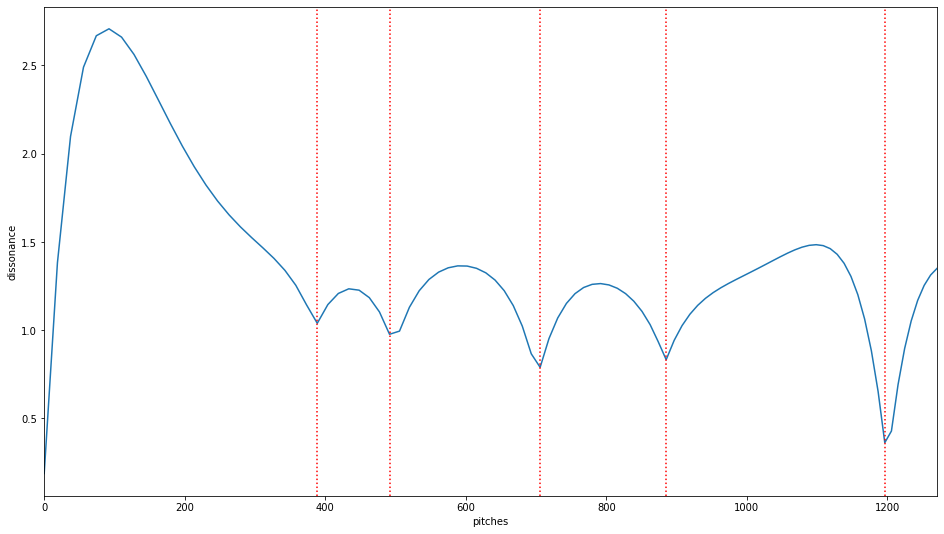

In [408]:
freqs = freq_space()
plot_dissonance_curve(freqs, dissonance_curve(freqs, n_partials=5, model='cook2009'))

In [400]:
def modality_surface(ratio_space, base_f=440, n_partials=10, model='cook2009'):
    modalitiess = []
    xs = []
    ys = []
    for ratio1 in ratio_space:
        x = []
        y = []
        modalities = []
        for ratio2 in ratio_space:
            x.append((ratio2 - 1) * 1200)
            y.append((ratio1 - 1) * 1200)
            h_freqs, h_amps = harmonic_tone([base_f, base_f * ratio1, base_f * ratio1 * ratio2],
                                            n_partials=n_partials)
            d = modality(h_freqs, h_amps, model=model)
            modalities.append(d)
        xs.append(x)
        ys.append(y)
        modalitiess.append(modalities)
    xs = np.array(xs)
    ys = np.array(ys)
    modalitiess = np.array(modalitiess)
    return xs, ys, modalitiess

ratios = ratio_space(octaves=2 + 1/12, steps=100)
xs, ys, mod_surf = modality_surface(ratios, n_partials=5, model='cook2009')

-2.3070692428043187 2.3068123050258786


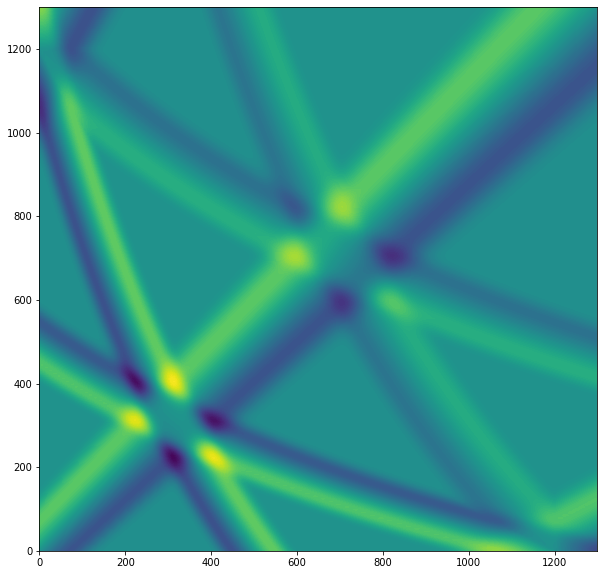

In [392]:
def plot_modality_surface(freqs, x, y, modalities):
    pitches = [freq_to_pitch(f, steps_per_octave=1200) for f in freqs]
    plt.figure(figsize=(10, 10))
    X = x
    Y = y
    Z = modalities
    print(np.min(Z), np.max(Z))
    plt.contourf(X, Y, Z, 100)

plot_modality_surface(freqs, xs, ys, mod_surf)

In [415]:
def tension_surface(ratio_space, base_f=440, n_partials=10, model='cook2009'):
    tensionss = []
    xs = []
    ys = []
    for ratio1 in ratio_space:
        x = []
        y = []
        tensions = []
        for ratio2 in ratio_space:
            x.append((ratio2 - 1) * 1200)
            y.append((ratio1 - 1) * 1200)
            h_freqs, h_amps = harmonic_tone([base_f, base_f * ratio1, base_f * ratio1 * ratio2],
                                            n_partials=n_partials)
            d = tension(h_freqs, h_amps, model=model)
            tensions.append(d)
        xs.append(x)
        ys.append(y)
        tensionss.append(tensions)
    xs = np.array(xs)
    ys = np.array(ys)
    tensionss = np.array(tensionss)
    return xs, ys, tensionss

ratios = ratio_space(octaves=2 + 1/12, steps=100)
xs, ys, tens_surf = tension_surface(ratios, n_partials=5, model='cook2009')

0.10021601705389618 6.221914358380234


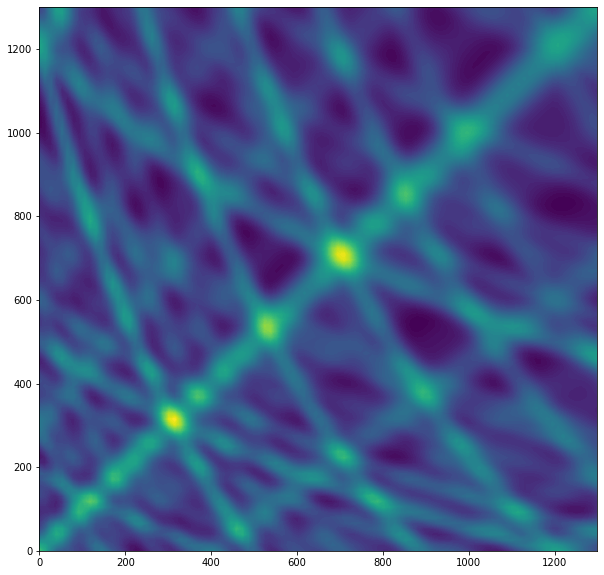

In [416]:
def plot_tension_surface(freqs, x, y, tensions):
    pitches = [freq_to_pitch(f, steps_per_octave=1200) for f in freqs]
    plt.figure(figsize=(10, 10))
    X = x
    Y = y
    Z = tensions
    print(np.min(Z), np.max(Z))
    plt.contourf(X, Y, Z, 100)

plot_tension_surface(freqs, xs, ys, tens_surf)

In [457]:
cents_tolerance = 8

main_pitch_in_hz = 55

relations = []

for idx, chord in enumerate(chords):
    pitches = chord.tony
    pitches_in_hz = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz)

    if len(pitches_in_hz) < 3:
        print(chord.syllable, chord.tony)
        continue

    pitches_in_hz.sort()
    f1, f2, f3 = pitches_in_hz
    h_freqs, h_amps = harmonic_tone([f1, f2, f3], n_partials=5)
    m = modality(h_freqs, h_amps, model='cook2009')
    t = tension(h_freqs, h_amps, model='cook2009')
    relation = [pitches_in_hz[1] / pitches_in_hz[0], pitches_in_hz[2] / pitches_in_hz[0]]
    print(idx, chord.syllable, m, t, chord.tony)

e [None, 2728, None]
lya [None, 2545, None]
lar [None, 2409, None]
de [None, 2226, None]
i [None, 2564, None]
i [None, 2538, None]
6 la 1.7399553871565416 2.1276907732254684 [2025, 2397, 2727]
7 i/qi 0.6077778642420082 1.2830170670458405 [2048, 2507, 2727]
8 le/me 1.0801479276399235 1.535597691605137 [2031, 2482, 2727]
9 i 1.4643473634246842 1.1496297507353266 [2084, 2507, 2756]
10 a 1.346107089584365 1.290577825181737 [2037, 2476, 2728]
11 uo -2.320379100489032 1.4495626321439075 [1786, 2333, 2620]
o [1508, 2423, None]
13 o/le 0.8330618477606155 2.019012906481062 [1653, 2070, 2410]
14 si 0.07640263653822964 2.4718164957773814 [1862, 2417, 2547]
15 a 1.587205749152858 1.2235923585204238 [1862, 2269, 2597]
16 uo 1.1940888625476795 3.3874610781180023 [2056, 2083, 2089]
17 a/sa 0.1841185365579709 2.0309231491401163 [2059, 2541, 2759]
18 i -0.40988924263575355 2.308899685962212 [2059, 2564, 2767]
i/a [2059, None, 2794]
20 a/da -1.606461941154132 0.6900306814799865 [2011, 2535, 2794]
21 a/m

In [422]:
# kriste aghsdga

chords = []
# starting solo of second voice
# 0
chords.append(Chord(1.28, ch([None, 2616, None]), hz2c([None, None, None]), [None, 2543, None], 'kri'))
chords.append(Chord(2.63, ch([None, 2598, None]), hz2c([None, None, None]), [None, 2543, None], 'ste'))
chords.append(Chord(3.03, ch([None, 2615, None]), hz2c([None, None, None]), [None, 2543, None], 'aghs'))
chords.append(Chord(3.38, ch([None, 2619, None]), hz2c([None, None, None]), [None, 2543, None], 'dga'))
chords.append(Chord(3.79, ch([None, 2823, None]), hz2c([None, None, None]), [None, 2747, None], 'mkvdre'))
chords.append(Chord(4.20, ch([None, 2499, None]), hz2c([None, None, None]), [None, 2432, None], 'tit'))

# first verse
# 6
chords.append(Chord(6.30,  ch([2197, 26, 756]), hz2c([None, None, None]), [2228, 2228, 2951], 'si'))
chords.append(Chord(6.82,  ch([2266, 16, 708]), hz2c([None, None, None]), [2228, 2228, 2951], 'kvdi'))
chords.append(Chord(7.32,  ch([2254, 28, 738]), hz2c([None, None, None]), [2228, 2228, 2951], 'li'))
chords.append(Chord(7.72,  ch([2220, 27, 729]), hz2c([None, None, None]), [2228, 2228, 2951], 'sa'))

chords.append(Chord(8.15,  ch([2172, 560,  764]), hz2c([None, None, None]), [2228, 2747, 2951], 'si'))
chords.append(Chord(8.61,  ch([2209, 525,  750]), hz2c([None, None, None]), [2228, 2747, 2951], 'kvdi'))
chords.append(Chord(8.99,  ch([2207, 543,  769]), hz2c([None, None, None]), [2228, 2747, 2951], 'li'))
chords.append(Chord(9.43,  ch([1834, 720, 1151]), hz2c([None, None, None]), [1843, 2543, 2951], 'sa/ta'))
chords.append(Chord(10.88, ch([1834, 720,  782]), hz2c([None, None, None]), [1843, 2543, 2543], 'i/li'))
chords.append(Chord(11.28, ch([2003, 537,  787]), hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(12.32, ch([2008, 551,  736]), hz2c([None, None, None]), [2024, 2543, 2747], 'trgun'))

chords.append(Chord(13.25, ch([1981, 550, 1030]), hz2c([None, None, None]), [2024, 2543, 3010], 've'))
chords.append(Chord(13.85, ch([2050, 503,  925]), hz2c([None, None, None]), [2024, 2543, 2951], 'li'))
chords.append(Chord(14.10, ch([1968, 579,  819]), hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(14.54, ch([1996, 548,  560]), hz2c([None, None, None]), [2024, 2543, 2543], 'sa'))
chords.append(Chord(15.02, ch([1998, 561,  783]), hz2c([None, None, None]), [2024, 2543, 2747], 'pla'))

chords.append(Chord(15.88, ch([1982,    581, 1027]), hz2c([None, None, None]), [2024, 2543, 3010], 've'))
chords.append(Chord(16.56, ch([2038,    520,  946]), hz2c([None, None, None]), [2024, 2543, 2951], 'bis'))
chords.append(Chord(16.85, ch([2039,    539,  730]), hz2c([None, None, None]), [2024, 2543, 2747], 'shi'))
chords.append(Chord(17.27, ch([2041,    703,  889]), hz2c([None, None, None]), [2024, 2747, 2951], 'na'))
chords.append(Chord(17.75, ch([2041,    523,  514]), hz2c([None, None, None]), [2024, 2543, 2543], 'a'))
chords.append(Chord(18.16, ch([None, 2431+69, -69]), hz2c([None, None, None]), [None, 2543, 2432], 'ta'))

chords.append(Chord(18.86, ch([2213, 502,  739]), hz2c([None, None, None]), [2228, 2747, 2951], 'tskho'))
chords.append(Chord(20.38, ch([2259, 337,  699]), hz2c([None, None, None]), [2228, 2543, 2951], 'vre'))
chords.append(Chord(21.48, ch([2100, 667,  725]), hz2c([None, None, None]), [2024, 2747, 2543], 'bis'))
chords.append(Chord(21.83, ch([1845, 736, 1247]), hz2c([None, None, None]), [1843, 2543, 3090], 'mi'))
chords.append(Chord(22.61, ch([1906, 680, 1055]), hz2c([None, None, None]), [1843, 2543, 2951], 'mni'))
chords.append(Chord(23.42, ch([1852, 512,  580]), hz2c([None, None, None]), [1843, 2432, 2432], "ch'e"))
chords.append(Chord(24.17, ch([1890, 327,  672]), hz2c([None, None, None]), [1843, 2228, 2543], 'be'))
chords.append(Chord(25.01, ch([2046,  9,   710]), hz2c([None, None, None]), [2024, 2024, 2747], 'li'))

# second verse
# 36
chords.append(Chord(27.81, ch([2045, 512,  901]), hz2c([None, None, None]), [2024, 2543, 2951], 'kri'))
chords.append(Chord(29.16, ch([2007, 564,  945]), hz2c([None, None, None]), [2024, 2543, 2951], 'ste'))
chords.append(Chord(29.64, ch([2004, 576,  952]), hz2c([None, None, None]), [2024, 2543, 2951], 'aghs'))
chords.append(Chord(30.00, ch([1994, 593, 1023]), hz2c([None, None, None]), [2024, 2543, 2951], 'dga'))
chords.append(Chord(30.40, ch([2000, 781,  787]), hz2c([None, None, None]), [2024, 2747, 2747], 'mkvdre'))
chords.append(Chord(30.79, ch([2030, 400,  744]), hz2c([None, None, None]), [2024, 2432, 2747], 'tit'))

# for next 6 chords bottom voice is wrong in gvm (both pitches and syllables)
# so i've taken them from tony
chords.append(Chord(32.15, [2180, 2175, 2894], hz2c([None, None, None]), [2228, 2228, 2951], 'si'))
chords.append(Chord(32.56, [2249, 2264, 2936], hz2c([None, None, None]), [2228, 2228, 2951], 'kvdi'))
chords.append(Chord(33.01, [2243, 2245, 2955], hz2c([None, None, None]), [2228, 2228, 2951], 'li'))
chords.append(Chord(33.35, [2197, 2210, 2973], hz2c([None, None, None]), [2228, 2228, 2951], 'ta'))

chords.append(Chord(33.74, [2228, 2751, 2893],     hz2c([None, None, None]), [2228, 2747, 2951], 'si'))
chords.append(Chord(34.14, [2211, 2737, 2945],     hz2c([None, None, None]), [2228, 2747, 2951], 'kvdi'))
chords.append(Chord(34.51, ch([2218, 520, 733]),   hz2c([None, None, None]), [2228, 2747, 2951], 'li'))
chords.append(Chord(34.89, ch([1836, 697, 1105]),  hz2c([None, None, None]), [1843, 2543, 2951], 'sa'))
chords.append(Chord(36.04, ch([None, None, 2570]), hz2c([None, None, None]), [None, None, 2543], 'i'))
chords.append(Chord(36.55, ch([2020, 498, 741]),   hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(37.56, ch([2028, 506, 709]),   hz2c([None, None, None]), [2024, 2543, 2747], 'trgun'))

chords.append(Chord(38.51, ch([2004, 521, 1008]), hz2c([None, None, None]), [2024, 2543, 3090], 've'))
chords.append(Chord(38.98, ch([2018, 497,  956]), hz2c([None, None, None]), [2024, 2543, 2951], 'li'))
chords.append(Chord(39.26, ch([2014, 513,  765]), hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(39.64, ch([2021, 508,  522]), hz2c([None, None, None]), [2024, 2543, 2543], 'sa'))
chords.append(Chord(40.06, ch([1991, 538,  767]), hz2c([None, None, None]), [2024, 2543, 2747], 'pla'))

chords.append(Chord(41.00, ch([1999, 531, 1039]), hz2c([None, None, None]), [2024, 2543, 3090], 've'))
chords.append(Chord(41.62, ch([2028, 519,  965]), hz2c([None, None, None]), [2024, 2543, 2951], 'bis'))
chords.append(Chord(41.87, ch([2031, 519,  747]), hz2c([None, None, None]), [2024, 2543, 2747], 'shi'))
chords.append(Chord(42.27, ch([2023, 686,  927]), hz2c([None, None, None]), [2024, 2747, 2951], 'na'))
chords.append(Chord(42.72, ch([2023, 500,  502]), hz2c([None, None, None]), [2024, 2543, 2543], 'a'))
chords.append(Chord(43.09, ch([1981, 384,  464]), hz2c([None, None, None]), [2024, 2432, 2432], 'ta'))

chords.append(Chord(43.69, ch([2213, 502,  739]), hz2c([None, None, None]), [2228, 2747, 2951], 'tskho'))
chords.append(Chord(45.46, ch([2247, 322,  695]), hz2c([None, None, None]), [2228, 2543, 2951], 'vre'))
chords.append(Chord(46.59, ch([2099, 615, None]), hz2c([None, None, None]), [2024, 2747, None], 'bis'))
chords.append(Chord(47.10, ch([1828, 707, 1213]), hz2c([None, None, None]), [1843, 2543, 3090], 'mi'))
chords.append(Chord(47.84, ch([1848, 710, 1113]), hz2c([None, None, None]), [1843, 2543, 2951], 'mni'))
chords.append(Chord(48.65, ch([1689, 701,  703]), hz2c([None, None, None]), [1843, 2432, 2432], "ch'e"))
chords.append(Chord(49.44, ch([1844, 336,  686]), hz2c([None, None, None]), [1843, 2228, 2543], 'be'))
chords.append(Chord(50.25, ch([2036+18, -18, 697-18]), hz2c([None, None, None]), [2024, 2024, 2747], 'li'))

# third verse
# 72
chords.append(Chord(53.23, ch([2035, 514, 904]), hz2c([None, None, None]), [2024, 2543, 2951], 'kri'))
chords.append(Chord(54.49, ch([1991, 558, 951]), hz2c([None, None, None]), [2024, 2543, 2951], 'ste'))
chords.append(Chord(55.09,   [2000, None, 2936], hz2c([None, None, None]), [2024, None, 2951], 'aghs'))
chords.append(Chord(55.32, ch([2020, 530, 928]), hz2c([None, None, None]), [2024, 2543, 2951], 'dga'))
chords.append(Chord(55.69, ch([2025, 703, 718]), hz2c([None, None, None]), [2024, 2747, 2747], 'mkvdre'))
chords.append(Chord(56.09, ch([2013, 415, 698]), hz2c([None, None, None]), [2024, 2432, 2747], 'tit'))

chords.append(Chord(57.47, ch([2118, 37, 746]), hz2c([None, None, None]), [2228, 2228, 2951], 'si'))
chords.append(Chord(57.87, ch([2226,  6, 695]), hz2c([None, None, None]), [2228, 2228, 2951], 'kvdi'))
chords.append(Chord(58.31, ch([2232,  9, 695]), hz2c([None, None, None]), [2228, 2228, 2951], 'li'))
chords.append(Chord(58.65, ch([2197,  2, 738]), hz2c([None, None, None]), [2228, 2228, 2951], 'ta'))

chords.append(Chord(59.00, ch([2188, 484, 697]),   hz2c([None, None, None]), [2228, 2747, 2951], 'si'))
chords.append(Chord(59.39, ch([2209, 527, 719]),   hz2c([None, None, None]), [2228, 2747, 2951], 'kvdi'))
chords.append(Chord(59.76, ch([2203, 534, 720]),   hz2c([None, None, None]), [2228, 2747, 2951], 'li'))
chords.append(Chord(60.16, ch([1793, 716, 1143]),  hz2c([None, None, None]), [1843, 2543, 2951], 'sa/ta'))
chords.append(Chord(61.30, ch([None, None, 2529]), hz2c([None, None, None]), [None, None, 2951], 'i'))
chords.append(Chord(61.86, ch([1997, 501, 743]),   hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(62.81, ch([2020, 492, 718]),   hz2c([None, None, None]), [2024, 2543, 2747], 'trgun'))

chords.append(Chord(63.63, ch([2007, 497, 988]), hz2c([None, None, None]), [2024, 2543, 3090], 've'))
chords.append(Chord(64.29, ch([2012, 503, 931]), hz2c([None, None, None]), [2024, 2543, 2951], 'li'))
chords.append(Chord(64.49, ch([2013, 500, 771]), hz2c([None, None, None]), [2024, 2543, 2747], 'da'))
chords.append(Chord(64.83, ch([2035, 471, 497]), hz2c([None, None, None]), [2024, 2543, 2543], 'sa'))
chords.append(Chord(65.26, ch([2013, 505, 748]), hz2c([None, None, None]), [2024, 2543, 2747], 'pla'))

chords.append(Chord(66.13, ch([1958, 554, 1045]), hz2c([None, None, None]), [2024, 2543, 3090], 've'))
chords.append(Chord(66.76, ch([1989, 545,  955]), hz2c([None, None, None]), [2024, 2543, 2951], 'bis'))
chords.append(Chord(67.00, ch([2000, 535,  705]), hz2c([None, None, None]), [2024, 2543, 2747], 'shi'))
chords.append(Chord(67.39, ch([2006, 692,  910]), hz2c([None, None, None]), [2024, 2747, 2951], 'na'))
chords.append(Chord(67.86, ch([2006, 476,  542]), hz2c([None, None, None]), [2024, 2543, 2543], 'a'))
chords.append(Chord(68.27, ch([1997, 347,  509]), hz2c([None, None, None]), [2024, 2432, 2432], 'ta'))

chords.append(Chord(68.95, ch([2220, 489, 716]),  hz2c([None, None, None]), [2228, 2747, 2951], 'tskho'))
chords.append(Chord(70.79, ch([2245, 317, 679]),  hz2c([None, None, None]), [2228, 2543, 2951], 'vre'))
chords.append(Chord(72.04, [2105, 2755, None],    hz2c([None, None, None]), [2024, 2747, None], 'bis'))
chords.append(Chord(72.61, ch([1791, 742, 1215]), hz2c([None, None, None]), [1843, 2543, 3090], 'mi'))
chords.append(Chord(73.40, ch([1853, 694, 1082]), hz2c([None, None, None]), [1843, 2543, 2951], 'mni'))
chords.append(Chord(74.29, ch([1701, 658, 667]),  hz2c([None, None, None]), [1843, 2432, 2432], "ch'e"))
chords.append(Chord(75.13, ch([1800, 336, 709]),  hz2c([None, None, None]), [1843, 2136, 2543], 'be'))
chords.append(Chord(76.20, ch([2004, 25, 720]),   hz2c([None, None, None]), [2024, 2024, 2747], 'li'))


In [424]:
cents_tolerance = 8

main_pitch_in_hz = 55

relations = []

for chord in chords:
    pitches = chord.gvm
    pitches_in_hz = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz)

    if len(pitches_in_hz) < 3:
        print(chord.syllable, chord.gvm)
        continue

    pitches_in_hz.sort()
    f1, f2, f3 = pitches_in_hz
    h_freqs, h_amps = harmonic_tone([f1, f2, f3], n_partials=5)
    m = modality(h_freqs, h_amps, model='cook2009')
    t = tension(h_freqs, h_amps, model='cook2009')
    relation = [pitches_in_hz[1] / pitches_in_hz[0], pitches_in_hz[2] / pitches_in_hz[0]]
    print(chord.syllable, m, t, chord.gvm)

kri [None, 2616, None]
ste [None, 2598, None]
aghs [None, 2615, None]
dga [None, 2619, None]
mkvdre [None, 2823, None]
tit [None, 2499, None]
si 0.6331484912077985 1.4850738644466663 [2197, 2223, 2953]
kvdi 1.1370166174334368 1.5345696773594435 [2266, 2282, 2974]
li 0.8573987398958371 1.3720255149500715 [2254, 2282, 2992]
sa 0.9526821690579285 1.3623757127095408 [2220, 2247, 2949]
si -0.9469927380212081 1.5302260380551245 [2172, 2732, 2936]
kvdi -0.6784026652320737 1.1955795427684828 [2209, 2734, 2959]
li -0.8504022494588613 0.9801637311446855 [2207, 2750, 2976]
sa/ta 0.25383318353607576 1.402320826360259 [1834, 2554, 2985]
i/li -0.6284681406298904 0.946507545227184 [1834, 2554, 2616]
da -1.5327038666602748 0.6632487770015325 [2003, 2540, 2790]
trgun -1.1314080157767143 1.9962459290017105 [2008, 2559, 2744]
ve 2.300803391340653 1.2801305880077605 [1981, 2531, 3011]
li 2.3365520555204498 1.8752611374361183 [2050, 2553, 2975]
da -1.9576911979282454 1.8024320649126198 [1968, 2547, 2787]
s

In [425]:
# dale koja

chords = []

# starting solo of second voice
# 0
chords.append(Chord(3.49, ch([None, 2771, None]), hz2c([None, 272.5, None]), [None, 2850, None], 'a'))
chords.append(Chord(4.30, ch([None, 2785, None]), hz2c([None, 275.1, None]), [None, 2850, None], 'i'))
chords.append(Chord(4.70, ch([None, 2798, None]), hz2c([None, 277.0, None]), [None, 2850, None], 'ha'))
chords.append(Chord(6.46, ch([None, 2970, None]), hz2c([None, 305.4, None]), [None, 3010, None], 'ri'))
chords.append(Chord(7.02, ch([None, 2820, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'ro'))

# first verse
# 5
chords.append(Chord(7.76,  ch([2280, 377, 583]), hz2c([204.5, 256.2, 286.3]), [2341, 2680, 2850], 'ra'))
# fixme middle and top in tony
chords.append(Chord(8.54,  ch([2112, 353, 682]), hz2c([185.8, 256.2, 286.3]), [2114, 2499, 2850], 'sha'))
chords.append(Chord(9.44,  ch([1877, 765, 768]), hz2c([163.4, 256.2, 286.3]), [1877, 2680, 2680], 're'))
chords.append(Chord(10.11, ch([1902, 530, 889]), hz2c([165.6, 256.2, 286.3]), [1972, 2499, 2850], 'ro'))
chords.append(Chord(10.94, ch([1905, 378, 718]), hz2c([165.0, 256.2, 286.3]), [1972, 2341, 2680], 'sha'))
chords.append(Chord(12.49, ch([2088, 476, 900]), hz2c([183.8, 256.2, 286.3]), [2088, 2564, 3010], 'ra'))
chords.append(Chord(13.99, ch([2114, 384, 726]), hz2c([187.3, 256.2, 286.3]), [2114, 2499, 2850], 'sha'))

chords.append(Chord(15.38, ch([2253, 549, 844]), hz2c([209.3, 256.2, 286.3]), [2341, 2850, 3110], 'da'))
chords.append(Chord(15.96, ch([2272, 535, 855]), hz2c([209.3, 256.2, 286.3]), [2341, 2850, 3110], 'le'))
chords.append(Chord(16.64, ch([2318, 466, 694]), hz2c([210.1, 256.2, 286.3]), [2341, 2850, 3010], 'ko'))
chords.append(Chord(17.25, ch([2307, 454, 548]), hz2c([209.3, 256.2, 286.3]), [2341, 2850, 2850], 'jas'))

chords.append(Chord(17.87, ch([2299, 722, 750]), hz2c([207.7, 256.2, 286.3]), [2341, 3010, 3010], 'khel'))
chords.append(Chord(18.42, ch([2324, 539, 766]), hz2c([211.1, 256.2, 286.3]), [2341, 2850, 3110], 'ghva'))
chords.append(Chord(19.09, ch([2304, 369, 694]), hz2c([208.3, 256.2, 286.3]), [2341, 2680, 3010], 'zha'))
chords.append(Chord(19.70, ch([2149, 296, 660]), hz2c([190.0, 256.2, 286.3]), [2172, 2499, 2850], 'le'))
chords.append(Chord(20.45, ch([1913, 600, 732]), hz2c([166.4, 256.2, 286.3]), [1933, 2636, 2636], 're'))
chords.append(Chord(20.98, ch([1931, 486, 886]), hz2c([170.1, 256.2, 286.3]), [1933, 2417, 2850], 'ro'))
chords.append(Chord(21.58, ch([1933, 377, 699]), hz2c([167.4, 256.2, 286.3]), [1933, 2341, 2636], 'sha'))
chords.append(Chord(22.87, ch([2117, 537, 703]), hz2c([187.1, 256.2, 286.3]), [2155, 2850, 2850], 'ra'))
chords.append(Chord(24.17, ch([2155, 352, 677]), hz2c([190.6, 256.2, 286.3]), [2155, 2510, 2850], 'sha'))
chords.append(Chord(25.50, ch([2307,   1,  19]), hz2c([209.3, 256.2, 286.3]), [2341, 2341, 2341], 'sha'))

# second verse
# 26
chords.append(Chord(27.47, ch([None, 2826, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'sha'))
chords.append(Chord(28.11, ch([None, 2804, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'i'))
chords.append(Chord(28.49, ch([None, 2856, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'ho'))

chords.append(Chord(29.70, ch([2304, 665, 818]), hz2c([207.8, 256.2, 286.3]), [2341, 3010, 3110], 'ri'))
chords.append(Chord(30.26, ch([2327, 553, 771]), hz2c([211.4, 256.2, 286.3]), [2341, 2850, 3110], 'ro'))
chords.append(Chord(30.82, ch([2310, 415, 711]), hz2c([208.8, 256.2, 286.3]), [2341, 2680, 3010], 'ra'))
chords.append(Chord(31.37, ch([2138, 357, 706]), hz2c([188.6, 256.2, 286.3]), [2114, 2499, 2850], 'sha'))
chords.append(Chord(31.59, ch([2138, 357, 307]), hz2c([188.6, 256.2, 286.3]), [2114, 2499, 2499], 'a'))
chords.append(Chord(32.02, ch([1921, 718, 730]), hz2c([167.5, 256.2, 286.3]), [1877, 2680, 2680], 're'))
chords.append(Chord(32.58, ch([1912, 541, 934]), hz2c([164.9, 256.2, 286.3]), [1877, 2499, 2850], 'ro'))
chords.append(Chord(33.17, ch([1927, 406, 743]), hz2c([167.2, 256.2, 286.3]), [1877, 2341, 2680], 'sha'))
chords.append(Chord(34.42, ch([2160, 509, 686]), hz2c([191.4, 256.2, 286.3]), [2172, 2680, 3010], 'ra'))
chords.append(Chord(35.60, ch([2184, 330, 865]), hz2c([193.7, 256.2, 286.3]), [2172, 2499, 2850], 'sha'))

# fixme tony
chords.append(Chord(36.70, ch([2310, 459, 815]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'khel'))
chords.append(Chord(37.16, ch([2318, 534, 815]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3110], 'ghva'))
chords.append(Chord(37.75, ch([2354, 397, 686]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'zha'))
chords.append(Chord(38.26, ch([None, 2866, 29]),  hz2c([ None, 256.2, 286.3]), [None, 2850, 3010], 'lekh'))
chords.append(Chord(38.82, ch([2337, 480, 719]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], 'tet'))
chords.append(Chord(39.30, ch([2337, 387, 772]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], 'nam'))
chords.append(Chord(39.87, ch([1986, 714, 1044]), hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2850], 'ko'))
chords.append(Chord(40.37, ch([1773, 654, 1081]), hz2c([193.7, 256.2, 286.3]), [1773, 2499, 2850], 'jas'))
chords.append(Chord(41.00, ch([1981, 683, 691]),  hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2680], 're'))
chords.append(Chord(41.47, ch([2017, 398, 639]),  hz2c([193.7, 256.2, 286.3]), [1972, 2417, 2680], 'ro'))
chords.append(Chord(42.06, ch([2009, 325, 667]),  hz2c([193.7, 256.2, 286.3]), [1972, 2341, 2680], 'sha'))
chords.append(Chord(43.18, ch([2168, 488, 688]),  hz2c([193.7, 256.2, 286.3]), [2172, 2680, 2850], 'ra'))
chords.append(Chord(44.29, ch([2207, 345, 649]),  hz2c([193.7, 256.2, 286.3]), [2172, 2564, 2850], 'sha'))
chords.append(Chord(45.42, ch([2355,  21, -12]),  hz2c([193.7, 256.2, 286.3]), [2341, 2341, 2341], 'sha'))

# third verse
# 53
# fixme tony and redux
chords.append(Chord(47.32, ch([None, 2846, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'sha'))
chords.append(Chord(47.92, ch([None, 2843, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'i'))
chords.append(Chord(48.20, ch([None, 2856, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'ho'))

chords.append(Chord(49.37, ch([2293, 642, 837]), hz2c([207.8, 256.2, 286.3]), [2341, 3010, 3110], 'ri'))
chords.append(Chord(49.79, ch([2326, 539, 831]), hz2c([211.4, 256.2, 286.3]), [2341, 2850, 3110], 'ro'))
chords.append(Chord(50.36, ch([2326, 379, 734]), hz2c([208.8, 256.2, 286.3]), [2341, 2680, 3010], 'ra'))
chords.append(Chord(50.95, ch([2162, 684, 711]), hz2c([188.6, 256.2, 286.3]), [2114, 2499, 2850], 'sha'))
chords.append(Chord(51.51, ch([1984, 728, 1043]), hz2c([167.5, 256.2, 286.3]), [1877, 2680, 2680], 're'))
chords.append(Chord(52.02, ch([1984, 486, 886]), hz2c([164.9, 256.2, 286.3]), [1877, 2499, 2850], 'ro'))
chords.append(Chord(52.59, ch([1996, 364, 682]), hz2c([167.2, 256.2, 286.3]), [1877, 2341, 2680], 'sha'))
chords.append(Chord(53.75, ch([2183, 514, 698]), hz2c([191.4, 256.2, 286.3]), [2172, 2680, 3010], 'ra'))
chords.append(Chord(54.90, ch([2199, 360, 678]), hz2c([193.7, 256.2, 286.3]), [2172, 2499, 2850], 'sha'))

chords.append(Chord(56.03, ch([2357, 398, 778]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'chu'))
chords.append(Chord(56.39, ch([2341, 485, 842]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3110], 'kvan'))
chords.append(Chord(56.95, ch([2336, 442, 748]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'tkhe'))
chords.append(Chord(57.46, ch([2264, 592, 607]),  hz2c([193.7, 256.2, 286.3]), [2264, 2850, 3010], 'ral'))
chords.append(Chord(57.92, ch([2335, 365, 713]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], 'kho'))
chords.append(Chord(58.38, ch([2369, 477, 786]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], "q'el"))
chords.append(Chord(58.88, ch([2337, 376, 699]), hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2850], 'pe'))
chords.append(Chord(59.35, ch([2137, 313, 774]), hz2c([193.7, 256.2, 286.3]), [1773, 2499, 2850], 'nekh'))
chords.append(Chord(59.65, ch([None, 2833, None]), hz2c([None, 256.2, None]), [None, 2499, None], 'kh'))
chords.append(Chord(59.97, ch([2011, 674, 1034]),  hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2680], 're'))
chords.append(Chord(60.45, [1995, 2514, 2891],  hz2c([193.7, 256.2, 286.3]), [1972, 2417, 2680], 'ro'))
chords.append(Chord(60.59, [1995, 2514, 3092],  hz2c([193.7, 256.2, 286.3]), [1972, 2417, 2680], 'o'))
chords.append(Chord(60.66, [1995, 2514, 2905],  hz2c([193.7, 256.2, 286.3]), [1972, 2417, 2680], 'o'))
chords.append(Chord(60.98, ch([2015, 336, 647]),  hz2c([193.7, 256.2, 286.3]), [1972, 2341, 2680], 'sha'))
chords.append(Chord(62.03, ch([2185, 527, 693]),  hz2c([193.7, 256.2, 286.3]), [2172, 2680, 2850], 'ra'))
chords.append(Chord(63.07, ch([2207, 377, 666]),  hz2c([193.7, 256.2, 286.3]), [2172, 2564, 2850], 'sha'))
chords.append(Chord(64.15, ch([2355,  19,  22]),  hz2c([193.7, 256.2, 286.3]), [2341, 2341, 2341], 'sha'))

# fourth verse
# 80
chords.append(Chord(65.67, ch([None, 2385, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'sha'))
chords.append(Chord(66.31, ch([None, 2307, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'i'))
chords.append(Chord(66.68, ch([None, 2870, None]), hz2c([None, 280.3, None]), [None, 2850, None], 'ho'))

chords.append(Chord(67.76, ch([2301, 675, 815]), hz2c([207.8, 256.2, 286.3]), [2341, 3010, 3110], 'ri'))
chords.append(Chord(68.16, ch([2352, 526, 832]), hz2c([211.4, 256.2, 286.3]), [2341, 2850, 3110], 'ro'))
chords.append(Chord(68.72, ch([2361, 354, 694]), hz2c([208.8, 256.2, 286.3]), [2341, 2680, 3010], 'ra'))
chords.append(Chord(69.26, ch([2207, 300, 667]), hz2c([188.6, 256.2, 286.3]), [2114, 2499, 2850], 'sha'))
chords.append(Chord(69.82, ch([2009, 640, 1013]), hz2c([167.5, 256.2, 286.3]), [1877, 2680, 2680], 're'))
chords.append(Chord(70.35, ch([1989, 523, 908]), hz2c([164.9, 256.2, 286.3]), [1877, 2499, 2850], 'ro'))
chords.append(Chord(71.00, ch([1999, 361, 712]), hz2c([167.2, 256.2, 286.3]), [1877, 2341, 2680], 'sha'))
chords.append(Chord(72.08, ch([2183, 524, 706]), hz2c([191.4, 256.2, 286.3]), [2172, 2680, 3010], 'ra'))
chords.append(Chord(73.29, ch([2200, 420, 681]), hz2c([193.7, 256.2, 286.3]), [2172, 2499, 2850], 'sha'))

chords.append(Chord(74.35, ch([2301, 449, 859]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'zhi'))
chords.append(Chord(74.75, ch([2318, 498, 874]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3110], 'kan'))
chords.append(Chord(75.28, ch([2340, 437, 750]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 3010], 'ghom'))
chords.append(Chord(75.80, ch([None, 2734, 141]),  hz2c([None, 256.2, 286.3]), [None, 2850, 3010], 'lar'))
chords.append(Chord(76.32, ch([2302, 389, 702]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], 'khen'))
chords.append(Chord(76.81, ch([2319, 369, 802]),  hz2c([193.7, 256.2, 286.3]), [2341, 2850, 2850], 'de'))
chords.append(Chord(77.30, ch([2328, 370, 733]), hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2850], 'rya'))
chords.append(Chord(77.78, ch([2135, 375, 791]), hz2c([193.7, 256.2, 286.3]), [1773, 2499, 2850], 'lekh'))
chords.append(Chord(78.40, ch([1964, 704, 764]),  hz2c([193.7, 256.2, 286.3]), [1972, 2680, 2680], 're'))
chords.append(Chord(78.82, ch([1993, 504, 739]),  hz2c([193.7, 256.2, 286.3]), [1972, 2417, 2680], 'ro'))
chords.append(Chord(79.40, ch([2033, 438, 693]),  hz2c([193.7, 256.2, 286.3]), [1972, 2341, 2680], 'sha'))
chords.append(Chord(79.98, ch([None, 2351, None]),  hz2c([None, 256.2, None]), [None, 2341, None], 'a'))
chords.append(Chord(80.58, ch([2191, 455, 710]),  hz2c([193.7, 256.2, 286.3]), [2172, 2680, 2850], 'ra'))
chords.append(Chord(81.64, ch([2223, 353, 680]),  hz2c([193.7, 256.2, 286.3]), [2172, 2564, 2850], 'sha'))
chords.append(Chord(82.77, ch([2370,   2,   9]),  hz2c([193.7, 256.2, 286.3]), [2341, 2341, 2341], 'sha'))


In [426]:
cents_tolerance = 8

main_pitch_in_hz = 55

relations = []

for chord in chords:
    pitches = chord.gvm
    pitches_in_hz = []
    for p_idx, pitch in enumerate(pitches):
        if pitch is None:
            continue
        pitch_in_hz = calc_hz(pitch, main_pitch_in_hz)
        pitches_in_hz.append(pitch_in_hz)

    if len(pitches_in_hz) < 3:
        print(chord.syllable, chord.gvm)
        continue

    pitches_in_hz.sort()
    f1, f2, f3 = pitches_in_hz
    h_freqs, h_amps = harmonic_tone([f1, f2, f3], n_partials=5)
    m = modality(h_freqs, h_amps, model='cook2009')
    t = tension(h_freqs, h_amps, model='cook2009')
    relation = [pitches_in_hz[1] / pitches_in_hz[0], pitches_in_hz[2] / pitches_in_hz[0]]
    print(chord.syllable, m, t, chord.gvm)

a [None, 2771, None]
i [None, 2785, None]
ha [None, 2798, None]
ri [None, 2970, None]
ro [None, 2820, None]
ra 0.8543083280348313 1.3564647393377771 [2280, 2657, 2863]
sha 1.2268526763249723 3.257266298964089 [2112, 2465, 2794]
re 0.1362077140234536 0.9585385129534959 [1877, 2642, 2645]
ro 1.036948858078175 2.612468030074892 [1902, 2432, 2791]
sha 0.9942542239674774 2.075653515915691 [1905, 2283, 2623]
ra 2.265462666872944 2.425577040618075 [2088, 2564, 2988]
sha 0.7718563858407317 1.9319611402383547 [2114, 2498, 2840]
da -2.001808861853818 1.9240312088635265 [2253, 2802, 3097]
le -0.9130200302324379 3.1051397189770187 [2272, 2807, 3127]
ko 0.6188782116714978 1.6735096542541743 [2318, 2784, 3012]
jas -1.2455895654381366 2.0871420276672157 [2307, 2761, 2855]
khel -0.5323940606321992 1.3118237388939644 [2299, 3021, 3049]
ghva -0.8236225967367442 0.9660118148677497 [2324, 2863, 3090]
zha 1.9414537471497155 2.207862631957072 [2304, 2673, 2998]
le -1.4910603825026842 1.6805125295646226 [214

In [10]:
# proc = Popen(['afplay', '/Users/a1111/Downloads/GVM097_KristeAghsdga_MVCM.mp3'])


def send_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")

        msg.append([note, cur_timbre, out_bus_idx])
        # print('sent', note,'to', out_bus_idx)
        client.send(msg)
#         time.sleep(0.001)
    except Exception as e:
        pass

ref_hz = 110

prev_time = 0
sleep_time = chords[0].timestamp
# time.sleep(sleep_time)

scale_mrg = [1508, 1604, 1691, 1731, 1775, 1874, 2070, 2226, 2333, 2409, 2476, 2545, 2620, 2728, 2794, 2884]

for idx, chord in enumerate(chords):
    if idx + 1 < len(chords):
        sleep_time = chords[idx + 1].timestamp - chords[idx].timestamp
    else:
        sleep_time = 2
    tony_no_nan = []
    redux_no_nan = []
    gvm_no_nan = []
    for j, p in enumerate(chord.tony):
        if p is not None:
            tony_no_nan.append(p)
            redux_no_nan.append(chord.redux[j])
            gvm_no_nan.append(chord.gvm[j])

    warning = ''
    diff = np.max(np.abs(np.array(tony_no_nan) - redux_no_nan))
    diff = np.max(np.abs(np.array(tony_no_nan) - gvm_no_nan))
    if diff > 25:
        warning = '!!!'
    print(idx, chord.syllable, chord.gvm, chord.tony, chord.redux, warning)
#     continue
    pitches = chord.tony
    best_pitches = []
    for p in pitches:
        if p is None:
            best_pitches.append(None)
            continue
        best_p = None
        for p2 in scale_mrg:
            if best_p is None or abs(best_p - p) > abs(p2 - p):
                best_p = p2
        best_pitches.append(best_p)
    tony_hzs = [calc_hz(pitch, ref_hz) for pitch in best_pitches]
#     for hz in gvm_hzs:
    for hz in tony_hzs:
        send_msg(hz, 0, 0)
    time.sleep(sleep_time)
# proc.terminate()


0 e [None, 2727, None] [None, 2728, None] [None, 2756, None] 
1 lya [None, 2545, None] [None, 2545, None] [None, 2584, None] 
2 lar [None, 2409, None] [None, 2409, None] [None, 2431, None] 
3 de [None, 2225, None] [None, 2226, None] [None, 2259, None] 
4 i [None, 2565, None] [None, 2564, None] [None, 2584, None] 
5 i [None, 2407, None] [None, 2538, None] [None, 2552, None] !!!
6 la [2022, 2406, 2724] [2025, 2397, 2727] [2055, 2431, 2756] 
7 i/qi [2051, 2505, 2727] [2048, 2507, 2727] [2055, 2501, 2724] 
8 le/me [2025, 2482, 2728] [2031, 2482, 2727] [2055, 2482, 2724] 
9 i [2086, 2507, 2757] [2084, 2507, 2756] [2106, 2501, 2775] 
10 a [2039, 2475, 2727] [2037, 2476, 2728] [2055, 2482, 2724] 
11 uo [1785, 2343, 2613] [1786, 2333, 2620] [1781, 2329, 2622] 
12 o [1516, 2422, None] [1508, 2423, None] [1507, 2399, None] 
13 o/le [1660, 2070, 2407] [1653, 2070, 2410] [1679, 2055, 2399] 
14 si [1860, 2392, 2573] [1862, 2417, 2547] [1851, 2431, 2552] !!!
15 a [1837, 2270, 2600] [1862, 2269, 2597

ValueError: zero-size array to reduction operation maximum which has no identity

In [29]:
def send_msg(note, cur_timbre, out_bus_idx):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")

        msg.append([note, cur_timbre, out_bus_idx])
        client.send(msg)
    except Exception as e:
        pass

ref_hz = 110

prev_time = 0
sleep_time = chords[0].timestamp

prev_notes = [None, None, None]
is_debug = True

for idx, chord in enumerate(chords):
    if idx + 1 < len(chords):
        sleep_time = chords[idx + 1].timestamp - chords[idx].timestamp
    else:
        sleep_time = 2

    if sleep_time < 0.0:#0.55:
        if not is_debug:
            time.sleep(sleep_time)
        continue

    tony_no_nan = []
    melodic_steps = []
    for j, p in enumerate(chord.tony):
        if p is not None:
            tony_no_nan.append(p)
            if prev_notes[j] is not None:
                step = chord.tony[j] - prev_notes[j]
                melodic_steps.append(step)
            else:
                melodic_steps.append(None)
        else:
            melodic_steps.append(None)

    intervals = None
    if len(tony_no_nan) == 3:
        pitches = copy.deepcopy(tony_no_nan)
        pitches.sort()
        intervals = [pitches[2] - pitches[0], pitches[2] - pitches[1], pitches[1] - pitches[0]]
    print(idx, '{:.2f}'.format(sleep_time), chord.syllable, chord.tony, melodic_steps, intervals)
    prev_notes = chord.tony

    if not is_debug:
        tony_hzs = [calc_hz(pitch, ref_hz) for pitch in chord.tony]
        for hz in tony_hzs:
            send_msg(hz, 0, 0)
        time.sleep(sleep_time)


0 1.20 e [None, 2728, None] [None, None, None] None
1 0.40 lya [None, 2545, None] [None, -183, None] None
2 0.42 lar [None, 2409, None] [None, -136, None] None
3 0.67 de [None, 2226, None] [None, -183, None] None
4 1.73 i [None, 2564, None] [None, 338, None] None
5 0.46 i [None, 2538, None] [None, -26, None] None
6 1.91 la [2025, 2397, 2727] [None, -141, None] [702, 330, 372]
7 1.61 i/qi [2048, 2507, 2727] [23, 110, 0] [679, 220, 459]
8 0.89 le/me [2031, 2482, 2727] [-17, -25, 0] [696, 245, 451]
9 0.52 i [2084, 2507, 2756] [53, 25, 29] [672, 249, 423]
10 0.44 a [2037, 2476, 2728] [-47, -31, -28] [691, 252, 439]
11 0.50 uo [1786, 2333, 2620] [-251, -143, -108] [834, 287, 547]
12 0.46 o [1508, 2423, None] [-278, 90, None] None
13 1.48 o/le [1653, 2070, 2410] [145, -353, None] [757, 340, 417]
14 0.70 si [1862, 2417, 2547] [209, 347, 137] [685, 130, 555]
15 0.70 a [1862, 2269, 2597] [0, -148, 50] [735, 328, 407]
16 2.04 uo [2056, 2083, 2089] [194, -186, -508] [33, 6, 27]
17 1.37 a/sa [2059

In [22]:
# bach, BWV 1087, canon 9

def send_msg(note, cur_timbre, out_bus_idx, dur):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")
        msg.append([note, cur_timbre, out_bus_idx, dur])
        client.send(msg)
    except Exception as e:
        pass


ref_hz = 261.63
base_sleep_time = 0.2
note_names  = ['c', 'C', 'd', 'e', 'f', 'F', 'g', 'a', 'b']
note_shifts = [  0,   1,   2,   4,   5,   6,   7,   9,  11]

melody = ['g0', 'b0', 'd1', 'g1', 'd1', 'b0', 'g0', 'd1',
          'd0', 'F0', 'a0', 'C0', 'e0', 'g0', 'C1', '-',
          'd1', 'a0', 'F0', 'd0', 'g0', 'b0', 'd1', 'g0',
          'e1', 'c1', 'a0', 'c1', 'F0', 'a0', ['d1', 'c1'], ['b0', 'a0']]
bass =   ['g-2', 'g-1', 'F-1', 'e-1', 'd-1', 'b-2', 'c-1', 'd-1']
prev = None
max_idx = len(melody) * 4 + 1
for i in range(max_idx):
    if max_idx - i < 4:
        base_sleep_time *= 1.3
    bars = []
    bars = [(i, 0)]
    if i > 0:
        bars += [(i - 1, 0)]
    if i > 0 and (i % 4 == 0):
        bars += [(i // 4, 1)]
    to_play = []
    for idx, mel_type in bars:
        if mel_type == 0:
            notes_to_parse = melody[idx % len(melody)]
        else:
            notes_to_parse = bass[idx % len(bass)]
        if type(notes_to_parse) == str:
            notes_to_parse = [notes_to_parse]
        sleep_time = base_sleep_time / len(notes_to_parse)
        start_time = 0
        for note in notes_to_parse:
            if note == '-':
                hz = None
            else:
                let = note_names.index(note[0])
                shift = int(note[1:]) * 1200 + note_shifts[let] * 100
                hz = calc_hz(shift, ref_hz)
            to_play.append((start_time, hz, sleep_time))
            start_time += sleep_time
            if i == max_idx - 1:
                break
    to_play.append((base_sleep_time, None, 0))
    to_play.sort(key=lambda x: x[0])
    prev_time = 0
    for start_time, hz, dur in to_play:
        sleep_time = start_time - prev_time
        prev_time = start_time
        time.sleep(sleep_time)
        send_msg(hz, 0, 0, dur)

In [58]:
# bach, BWV 1087, canon 9
# analyse intervals

def send_msg(note, cur_timbre, out_bus_idx, dur):
    try:
        msg = pyOSC3.OSCMessage()
        msg.setAddress("/synths")
        msg.append([note, cur_timbre, out_bus_idx, dur])
        client.send(msg)
    except Exception as e:
        pass

shifts = {
    0    : '1/1',
    200  : '9/8|10/9',
    300  : '6/5',
    400  : '5/4',
    500  : '4/3',
    600  : 'WAT',
    700  : '3/2',
    800  : '8/5',
    900  : '5/3',
    1000 : '16/9|9/5',
}

def find_shift(interval, shifts):
    octs = interval // 1200
    interval %= 1200
    ji = '?'
    if interval in shifts:
        ji = shifts[interval]
    return ji + '+' + str(octs)


ref_hz = 261.63
base_sleep_time = 0.5
note_names  = ['c', 'C', 'd', 'e', 'F', 'g', 'a', 'b']
note_shifts = [  0,   1,   2,   4,   6,   7,   9,  11]

melody = ['g0', 'b0', 'd1', 'g1', 'd1', 'b0', 'g0', 'd1',
          'd0', 'F0', 'a0', 'C0', 'e0', 'g0', 'C1', '-',
          'd1', 'a0', 'F0', 'd0', 'g0', 'b0', 'd1', 'g0',
          'e1', 'c1', 'a0', 'c1', 'F0', 'a0', ['d1', 'c1'], ['b0', 'a0']]
bass =   ['g-2', 'g-1', 'F-1', 'e-1', 'd-1', 'b-2', 'c-1', 'd-1']
prev = None
max_idx = len(melody) + 1
voices = [None, None, None]
voices_lets = [None, None, None]
for i in range(max_idx):
    if max_idx - i < 4:
        base_sleep_time *= 1.3
    bars = []
    bars = [(i, 0, 0)]
    if i > 0:
        bars += [(i - 1, 0, 1)]
    if i > 0 and (i % 4 == 0):
        bars += [(i // 4, 1, 2)]
    to_play = []
    for idx, mel_type, voice in bars:
        if mel_type == 0:
            notes_to_parse = melody[idx % len(melody)]
        else:
            notes_to_parse = bass[idx % len(bass)]
        if type(notes_to_parse) == str:
            notes_to_parse = [notes_to_parse]
        sleep_time = base_sleep_time / len(notes_to_parse)
        start_time = 0
        for note in notes_to_parse:
            if note == '-':
                hz = None
                shift = None
            else:
                let = note_names.index(note[0])
                shift = int(note[1:]) * 1200 + note_shifts[let] * 100
                hz = calc_hz(shift, ref_hz)
            to_play.append((start_time, hz, shift, sleep_time, voice, note))
            start_time += sleep_time
            if i == max_idx - 1:
                break
    to_play.append((base_sleep_time, None, None, 0, None, None))
    to_play.sort(key=lambda x: x[0])
    prev_time = 0
    for start_time, hz, shift, dur, voice, note in to_play:
        sleep_time = start_time - prev_time
        prev_time = start_time
        if sleep_time != 0:
            voices_no_nan = []
            for v in voices:
                if v is not None:
                    voices_no_nan.append(v)
            diffs = []
            if len(voices_no_nan) == 3:
                diffs = [voices[2] - voices[0],
                         voices[2] - voices[1],
                         voices[1] - voices[0]]
            elif len(voices_no_nan) == 2:
                diffs = [voices_no_nan[1] - voices_no_nan[0]]
            diffs = [abs(d) for d in diffs]
            diffs.sort()
            jis = [find_shift(d, shifts) for d in diffs]
            print(voices, voices_lets, diffs, jis)
        time.sleep(sleep_time)
        if voice is not None:
            voices[voice] = shift
            voices_lets[voice] = note
        send_msg(hz, 2, 0, dur)

[700, None, None] ['g0', None, None] [] []
[1100, 700, None] ['b0', 'g0', None] [400] ['5/4+0']
[1400, 1100, None] ['d1', 'b0', None] [300] ['6/5+0']
[1900, 1400, None] ['g1', 'd1', None] [500] ['4/3+0']
[1400, 1900, -500] ['d1', 'g1', 'g-1'] [500, 1900, 2400] ['4/3+0', '3/2+1', '1/1+2']
[1100, 1400, -500] ['b0', 'd1', 'g-1'] [300, 1600, 1900] ['6/5+0', '5/4+1', '3/2+1']
[700, 1100, -500] ['g0', 'b0', 'g-1'] [400, 1200, 1600] ['5/4+0', '1/1+1', '5/4+1']
[1400, 700, -500] ['d1', 'g0', 'g-1'] [700, 1200, 1900] ['3/2+0', '1/1+1', '3/2+1']
[200, 1400, -600] ['d0', 'd1', 'F-1'] [800, 1200, 2000] ['8/5+0', '1/1+1', '8/5+1']
[600, 200, -600] ['F0', 'd0', 'F-1'] [400, 800, 1200] ['5/4+0', '8/5+0', '1/1+1']
[900, 600, -600] ['a0', 'F0', 'F-1'] [300, 1200, 1500] ['6/5+0', '1/1+1', '6/5+1']
[100, 900, -600] ['C0', 'a0', 'F-1'] [700, 800, 1500] ['3/2+0', '8/5+0', '6/5+1']
[400, 100, -800] ['e0', 'C0', 'e-1'] [300, 900, 1200] ['6/5+0', '5/3+0', '1/1+1']
[700, 400, -800] ['g0', 'e0', 'e-1'] [300, 12